## The next cell will get a ~65 MB data file 'sequence.index', you only need to run the cell once

In [5]:
!wsl rm sequence.index 2>/dev/null
!wsl wget -nd ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/historical_data/former_toplevel/sequence.index -O sequence.index

.. 80% 13.1M 1s
 52400K .......... .......... .......... .......... .......... 80% 13.3M 1s
 52450K .......... .......... .......... .......... .......... 80% 8.30M 1s
 52500K .......... .......... .......... .......... .......... 80% 13.1M 1s
 52550K .......... .......... .......... .......... .......... 80% 11.5M 1s
 52600K .......... .......... .......... .......... .......... 80% 8.96M 1s
 52650K .......... .......... .......... .......... .......... 80% 10.2M 1s
 52700K .......... .......... .......... .......... .......... 80% 12.9M 1s
 52750K .......... .......... .......... .......... .......... 80% 11.1M 1s
 52800K .......... .......... .......... .......... .......... 80% 8.05M 1s
 52850K .......... .......... .......... .......... .......... 80% 11.6M 1s
 52900K .......... .......... .......... .......... .......... 80% 13.5M 1s
 52950K .......... .......... .......... .......... .......... 80% 11.7M 1s
 53000K .......... .......... .......... .......... .......... 80% 8.28M

# Interfacing with R

In [1]:
import os

from IPython.display import Image

import rpy2.robjects as robjects
import rpy2.robjects.lib.ggplot2 as ggplot2
from rpy2.robjects.functions import SignatureTranslatedFunction

import pandas as pd

from rpy2.robjects import pandas2ri
from rpy2.robjects import default_converter
from rpy2.robjects.conversion import localconverter

In [2]:
read_delim = robjects.r('read.delim')
seq_data = read_delim('sequence.index', header=True, stringsAsFactors=False)
#In R:
#  seq.data <- read.delim('sequence.index', header=TRUE, stringsAsFactors=FALSE)

In [3]:
print('This data frame has %d columns and %d rows' % (seq_data.ncol, seq_data.nrow))
print(seq_data.colnames)
#In R:
#  print(colnames(seq.data))
#  print(nrow(seq.data))
#  print(ncol(seq.data))

print('Columns in Python %d ' % robjects.r.ncol(seq_data)[0])

#access some functions
as_integer = robjects.r('as.integer')
match = robjects.r.match

my_col = match('READ_COUNT', seq_data.colnames)[0] # Vector returned
print('Type of read count before as.integer: %s' % seq_data[my_col - 1].rclass[0])
seq_data[my_col - 1] = as_integer(seq_data[my_col - 1])
print('Type of read count after as.integer: %s' % seq_data[my_col - 1].rclass[0])

my_col = match('BASE_COUNT', seq_data.colnames)[0] # Vector returned
seq_data[my_col - 1] = as_integer(seq_data[my_col - 1])

my_col = match('CENTER_NAME', seq_data.colnames)[0]
seq_data[my_col - 1] = robjects.r.toupper(seq_data[my_col - 1])
robjects.r.assign('seq.data', seq_data)
robjects.r('print(c("Column names in R: ",colnames(seq.data)))')

robjects.r('seq.data <- seq.data[seq.data$WITHDRAWN==0, ]')
#Lets remove all withdrawn sequences

robjects.r("seq.data <- seq.data[, c('STUDY_ID', 'STUDY_NAME', 'CENTER_NAME', 'SAMPLE_ID', 'SAMPLE_NAME', 'POPULATION', 'INSTRUMENT_PLATFORM', 'LIBRARY_LAYOUT', 'PAIRED_FASTQ', 'READ_COUNT', 'BASE_COUNT', 'ANALYSIS_GROUP')]")
#Lets shorten the dataframe

#Population as factor
robjects.r('seq.data$POPULATION <- as.factor(seq.data$POPULATION)')

This data frame has 26 columns and 187720 rows
 [1] "FASTQ_FILE"          "MD5"                 "RUN_ID"             
 [4] "STUDY_ID"            "STUDY_NAME"          "CENTER_NAME"        
 [7] "SUBMISSION_ID"       "SUBMISSION_DATE"     "SAMPLE_ID"          
[10] "SAMPLE_NAME"         "POPULATION"          "EXPERIMENT_ID"      
[13] "INSTRUMENT_PLATFORM" "INSTRUMENT_MODEL"    "LIBRARY_NAME"       
[16] "RUN_NAME"            "RUN_BLOCK_NAME"      "INSERT_SIZE"        
[19] "LIBRARY_LAYOUT"      "PAIRED_FASTQ"        "WITHDRAWN"          
[22] "WITHDRAWN_DATE"      "COMMENT"             "READ_COUNT"         
[25] "BASE_COUNT"          "ANALYSIS_GROUP"     

Columns in Python 26 
Type of read count before as.integer: character
Type of read count after as.integer: integer
 [1] "Column names in R: " "FASTQ_FILE"          "MD5"                
 [4] "RUN_ID"              "STUDY_ID"            "STUDY_NAME"         
 [7] "CENTER_NAME"         "SUBMISSION_ID"       "SUBMISSION_DATE"    
[10] "S

YRI,YRI,YRI,...,STU,STU,STU


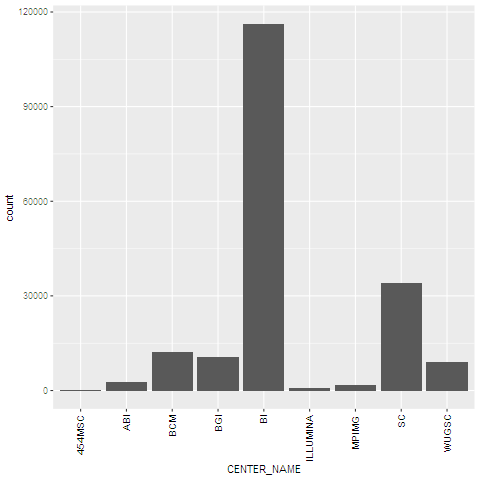

In [4]:
ggplot2.theme = SignatureTranslatedFunction(ggplot2.theme,
                                            init_prm_translate = {'axis_text_x': 'axis.text.x'})
bar = ggplot2.ggplot(seq_data) + ggplot2.geom_bar() + ggplot2.aes_string(x='CENTER_NAME') + ggplot2.theme(axis_text_x=ggplot2.element_text(angle=90, hjust=1))
robjects.r.png('out.png', type='cairo-png')
bar.plot()
dev_off = robjects.r('dev.off')
dev_off()
Image(filename='out.png')

In [5]:
#Get Yoruba and CEU
robjects.r('yri_ceu <- seq.data[seq.data$POPULATION %in% c("YRI", "CEU") & seq.data$BASE_COUNT < 2E9 & seq.data$READ_COUNT < 3E7, ]')
yri_ceu = robjects.r('yri_ceu')

In [6]:
yri_ceu

STUDY_ID,STUDY_NAME,CENTER_NAME,...,READ_COUNT,BASE_COUNT,ANALYSIS_GROUP
'SRP000032','1000Geno...,'BGI',...,"9,280,498","334,097,928",'high cov...
'SRP000032','1000Geno...,'BGI',,"9,571,982","344,591,352",'high cov...
'SRP000032','1000Geno...,'BGI',,"149,044","5,365,584",'high cov...
'SRP000032','1000Geno...,'BGI',,"2,057,690","74,076,840",'high cov...
...,...,...,,...,...,...
NA_character_,NA_character_,NA_character_,,NA_integer_,NA_integer_,NA_character_
'SRP000542','1000 Gen...,'BI',,"871,763","88,048,063",'low cove...
'SRP000542','1000 Gen...,'BI',,"8,623,980","871,021,980",'low cove...
'SRP000542','1000 Gen...,'BI',,"8,623,980","871,021,980",'low cove...


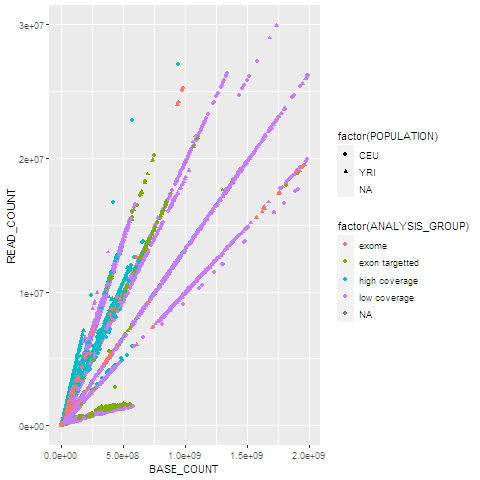

In [7]:
scatter = ggplot2.ggplot(yri_ceu) + ggplot2.aes_string(x='BASE_COUNT', y='READ_COUNT', shape='factor(POPULATION)', col='factor(ANALYSIS_GROUP)') + ggplot2.geom_point()
robjects.r.png('out.png')
scatter.plot()
dev_off = robjects.r('dev.off')
dev_off()
Image(filename='out.png')

In [10]:
# pd_yri_ceu = pandas2ri.ri2py(yri_ceu) doesn't work, see https://rpy2.github.io/doc/latest/html/pandas.html

with localconverter(robjects.default_converter + pandas2ri.converter):
  pd_yri_ceu = robjects.conversion.py2rpy(yri_ceu)

print(type(pd_yri_ceu))
pd_yri_ceu

<class 'rpy2.robjects.vectors.DataFrame'>


STUDY_ID,STUDY_NAME,CENTER_NAME,...,READ_COUNT,BASE_COUNT,ANALYSIS_GROUP
'SRP000032','1000Geno...,'BGI',...,"9,280,498","334,097,928",'high cov...
'SRP000032','1000Geno...,'BGI',,"9,571,982","344,591,352",'high cov...
'SRP000032','1000Geno...,'BGI',,"149,044","5,365,584",'high cov...
'SRP000032','1000Geno...,'BGI',,"2,057,690","74,076,840",'high cov...
...,...,...,,...,...,...
NA_character_,NA_character_,NA_character_,,NA_integer_,NA_integer_,NA_character_
'SRP000542','1000 Gen...,'BI',,"871,763","88,048,063",'low cove...
'SRP000542','1000 Gen...,'BI',,"8,623,980","871,021,980",'low cove...
'SRP000542','1000 Gen...,'BI',,"8,623,980","871,021,980",'low cove...


In [13]:
pd_yri_ceu

STUDY_ID,STUDY_NAME,CENTER_NAME,...,READ_COUNT,BASE_COUNT,ANALYSIS_GROUP
'SRP000032','1000Geno...,'BGI',...,"9,280,498","334,097,928",'high cov...
'SRP000032','1000Geno...,'BGI',,"9,571,982","344,591,352",'high cov...
'SRP000032','1000Geno...,'BGI',,"149,044","5,365,584",'high cov...
'SRP000032','1000Geno...,'BGI',,"2,057,690","74,076,840",'high cov...
...,...,...,,...,...,...
NA_character_,NA_character_,NA_character_,,NA_integer_,NA_integer_,NA_character_
'SRP000542','1000 Gen...,'BI',,"871,763","88,048,063",'low cove...
'SRP000542','1000 Gen...,'BI',,"8,623,980","871,021,980",'low cove...
'SRP000542','1000 Gen...,'BI',,"8,623,980","871,021,980",'low cove...


In [14]:
del pd_yri_ceu['PAIRED_FASTQ']
no_paired = pandas2ri.py2ri(pd_yri_ceu)
robjects.r.assign('no.paired', no_paired)
robjects.r("print(colnames(no.paired))")

AttributeError: __delitem__